In [1]:
cd ..

/Users/yanndubois/SSL-Risk-Decomposition


In [2]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
#!rm -rf /Users/yanndubois/.cache/torch/hub/YannDubs_SSL-Risk-Decomposition_main

# Collect all results

In [4]:
import torch
import pandas as pd
from utils.plotting import *
from utils.collect_results import *
from utils.causal import *
import numpy as np
import warnings
import logging
import hubconf

 No module named 'clip'


In [ ]:
metadata_df = hubconf.metadata_df(is_multiindex=False)
pred_train = 'torch_linear_lr'
results_ptrain = load_all_results(pattern=f"**/data_imagenet/**/*{pred_train}*/**/results_all.csv",
                                     skip_ifneq=dict(data="imagenet", pred=pred_train))
check_missing(results_ptrain, metadata_df)
results_ptrain = format_approx_results(results_ptrain, metadata_df, f_replace_arch=f_replace_arch, subset=None)


pred_test = 'torch_linear_hypopt'
results_ptest = load_all_results(pattern=f"**/data_imagenet/**/*{pred_test}*/**/results_all.csv",
                                     skip_ifneq=dict(data="imagenet", pred=pred_test))
check_missing(results_ptest, metadata_df)
results_ptest = format_approx_results(results_ptest, metadata_df, f_replace_arch=f_replace_arch, subset=None)

on=["enc","seed"]
ptrain_sffx = "_ptrain"
joined = results_ptest.reset_index().join(results_ptrain.reset_index().set_index(on), on=on, how="inner", rsuffix=ptrain_sffx
                                         ).set_index(["enc","seed"])
joined["sup_train_train"] = joined[f"sup_train_train{ptrain_sffx}"]
joined["train_train"] = joined[f"train_train{ptrain_sffx}"]

results = joined[[c for c in joined.columns if "_ptrain" not in c]]
results = make_risk_decomposition(results, traverse_path=["down","right","down"], is_print=True)
results, metadata_df = clean_results(results, metadata_df)
validate_results(results, metadata_df)

# filter out values that are suspiciously bad
to_del = ["selav2_rn50_ep400_2x160_4x96"]
to_keep = [i for i in results.index.get_level_values("enc") if i not in to_del]
results = results.loc[to_keep]

results.to_csv(f"notebooks/saved/results_joined.csv")

metadata_df = metadata_df.loc[to_keep]
df = pd.concat([results,metadata_df], axis=1)
df = df.replace(dict(ssl_mode={"hierarchical contrastive": "hierarchical"}))
df["n_augmentations"] = df["augmentations"].apply(lambda s: len(s))

# coarsens many different parameters for cleaner plots
#df = preprocess_features(df, round_dict={}, pow_dict={})

melted = melt(df)

> /Users/yanndubois/SSL-Risk-Decomposition/utils/collect_results.py(200)load_all_results()
    198     """Load all ssl and supervised results."""
    199     pdb.set_trace()
--> 200     files = list(results_dir.glob(pattern))
    201     print(f"Found {len(files)} result files to load.")
    202 



ipdb>  n


> /Users/yanndubois/SSL-Risk-Decomposition/utils/collect_results.py(201)load_all_results()
    199     pdb.set_trace()
    200     files = list(results_dir.glob(pattern))
--> 201     print(f"Found {len(files)} result files to load.")
    202 
    203     results = dict()



ipdb>  !files


[PosixPath('results/exp_riskdec/data_imagenet/ssl_simclr_resnet50_d8192_e100_m2/pred_torch_linear_lr/seed_123/results_all.csv'), PosixPath('results/exp_riskdec/data_imagenet/ssl_dissl_resnet50_dNone_e100_m2_augSmall/pred_torch_linear_lr/seed_123/results_all.csv'), PosixPath('results/exp_riskdec/data_imagenet/ssl_simclr_resnet50_dNone_e100_m2_data010/pred_torch_linear_lr/seed_123/results_all.csv'), PosixPath('results/exp_riskdec/data_imagenet/ssl_simclr_resnet50_dNone_e100_m2_headTNoneSNone/pred_torch_linear_lr/seed_123/results_all.csv'), PosixPath('results/exp_riskdec/data_imagenet/ssl_dissl_resnet50_d4096_e100_m2/pred_torch_linear_lr/seed_123/results_all.csv'), PosixPath('results/exp_riskdec/data_imagenet/ssl_simclr_resnet50_dNone_e100_m2_headTMlpSLin/pred_torch_linear_lr/seed_123/results_all.csv'), PosixPath('results/exp_riskdec/data_imagenet/ssl_speccl_bs384_ep100/pred_torch_linear_lr/seed_123/results_all.csv'), PosixPath('results/exp_riskdec/data_imagenet/ssl_dissl_resnet50_dNone_e

ipdb>  !files[0]


PosixPath('results/exp_riskdec/data_imagenet/ssl_simclr_resnet50_d8192_e100_m2/pred_torch_linear_lr/seed_123/results_all.csv')


ipdb>  !files[-1]


PosixPath('results/exp_dino/data_imagenet/ssl_dino_vitS16/pred_torch_linear_lr/seed_123/results_all.csv')


ipdb>  !files[10]


PosixPath('results/exp_riskdec/data_imagenet/ssl_simclr_resnet50_dNone_e100_m2_headTMlpSMlp/pred_torch_linear_lr/seed_123/results_all.csv')


ipdb>  !files[30]


PosixPath('results/exp_swav/data_imagenet/ssl_swav_rn50_ep200/pred_torch_linear_lr/seed_123/results_all.csv')


In [6]:
#non_core_params = ['date_published','top1acc_in1k_official','projection_nparameters']
core_params = ['objective','version','architecture','patch_size','z_dim','z_layer',
               "epochs","batch_size", "optimizer", "learning_rate", "weight_decay", "scheduler",
               "pretraining_data",'img_size','year',"nviews",'finetuning_data','projection_arch', "n_augmentations", "other"]
minimal_params = ['objective','version','architecture','patch_size','z_dim','z_layer',"pretraining_data",'finetuning_data']
df_core = df.set_index(core_params)[results.columns]
df_minimal = df.set_index(minimal_params)[results.columns]
melted_onlyComp = melt(df, components=COMPONENTS_ONLY)


## Controlled analysis: line curves
In the previous notebook we tried to analyse all models and components globally, now let us try considering the effect of specific more carefully.

### Effect of epochs
Let's analyze the effect of epochs in controlled settings.

**Hypothesis** from the ISSL perspective we know that training for longer gets more optimal representations and thus this should help both the usability and probe gen. The encoder gen will likely increase as there is more overfitting

In [7]:
df_epochs = melt(get_only_vary(df, ["epochs"], core_params, 
                               drop_cols=["year","optimizer","learning_rate", 'weight_decay','z_layer']))

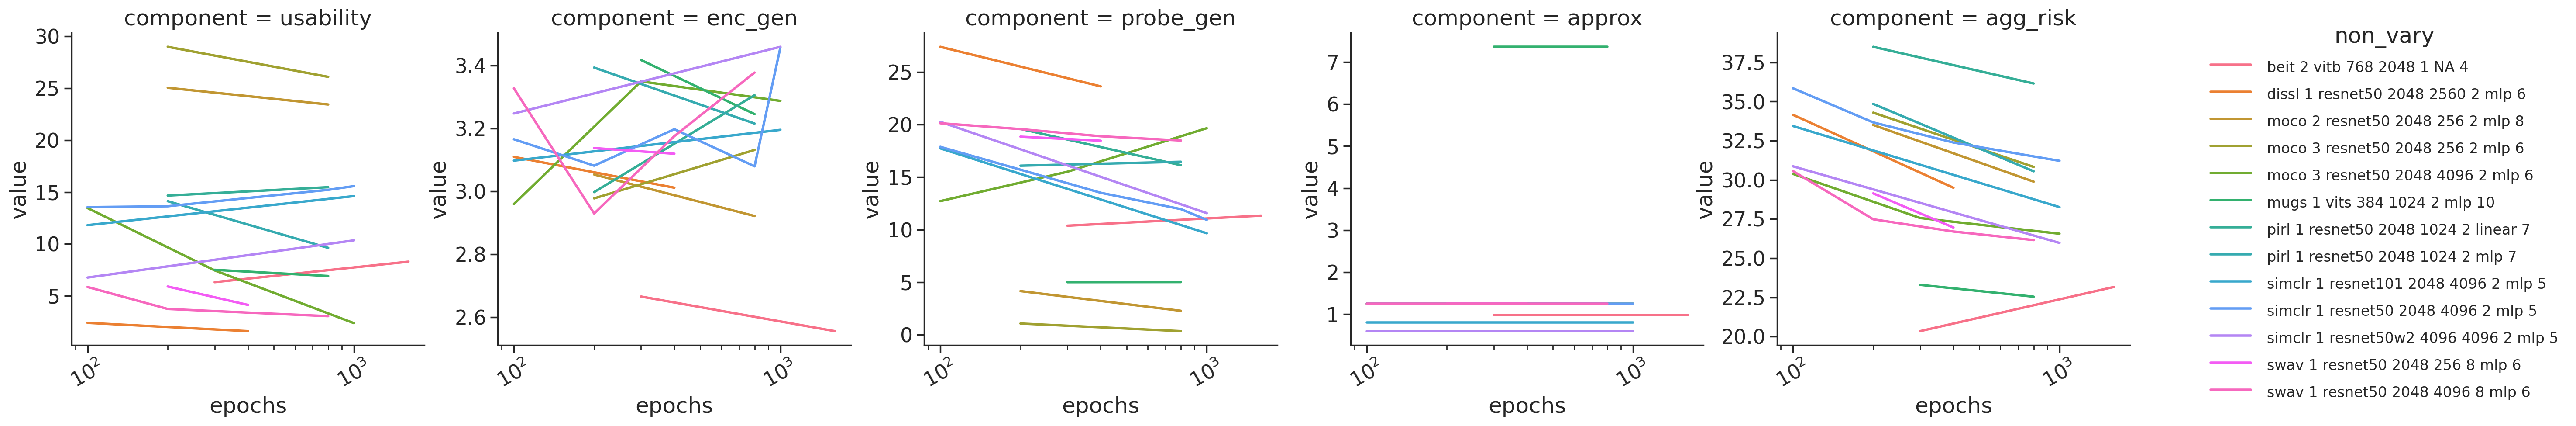

In [8]:
with plot_config():
    g = sns.relplot(data=df_epochs, x="epochs", y="value", hue="non_vary", col="component", kind="line",
                    facet_kws={'sharey': False})
    plt.setp(g._legend.get_texts(), fontsize=12)
    g.set_xticklabels(rotation=30)
    #g.set(yscale="log")
    g.set(xscale="log")
    #sns.move_legend(g, "lower center", bbox_to_anchor=(0., 0.5, 0.7, 1.102))

In [9]:
ols_summary(df_epochs, "epochs", condition=['non_vary', 'np.log({treatment})'], f_outcome="log_delta")
#ols_summary(df_epochs, "epochs", condition=['non_vary', '{treatment}'], f_outcome="", alpha=0.01)
#ols_summary(df_epochs, "epochs", condition=['non_vary', 'np.log({treatment})'], f_outcome="", alpha=0.01)
#ols_summary(df_epochs, "epochs", condition=['non_vary', 'np.log({treatment})'], f_outcome="log", alpha=0.02)

                                  probe_gen                                   
Dep. Variable:          np.log(value)   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.940
Method:                 Least Squares   F-statistic:                     37.30
Date:                Wed, 19 Oct 2022   Prob (F-statistic):           6.84e-10
Time:                        13:49:06   Log-Likelihood:                 16.706
No. Observations:                  31   AIC:                            -5.411
Df Residuals:                      17   BIC:                             14.66
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
rmse: 1.8344834197146997, delta: 0.3693787926121762
                                                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

We see that training for one epoch improves usability by -0.0043 on average over controlled studies. 
Given that all other parameters are kept fixed and assuming that there are no confounders between who performed those experiments (and released models) and the treatment
effect, we can view this as a causal relation. For example increasing training by 400 epochs, would improve usability by an estimated $1.72 \pm 0.4$ points, and the overall performance
by $1.44 \pm 0.4$ points. Note that the p value is very small.

Another reason why this can be viewed causally is that most papers from groups with much compute provides models at different epochs regardless of the hyperparameters.

One natural question is whether the linear assumption holds. Why would increasing epochs modify the error in absolute terms rather than, say, relative terms (percentages). To test that let us regress the log outcome.

We see that such relation is still highly statistically significant. The issue is that for most models we only have 2 values and thus it is hard to know whether the dependence is relative or absolute.

### Effect of batch size
Let's analyze the effect of batch size in controlled settings

**Hypothesis** increasing the batch size should might have different impact on diffferent types of ssl models. For contrastive and clustering it will generally improve the estimation of the objective which should improve usability and probe gen. But increasing batch size also decreases the number of steps which will decrease the previous two. So it will likely have better effect for longer epochs but unclear effects when small epochs. I.e. need to controll for epochs and ssl_mode. Finally, increasing batch size might help overfitting => decrease encoder generalization.

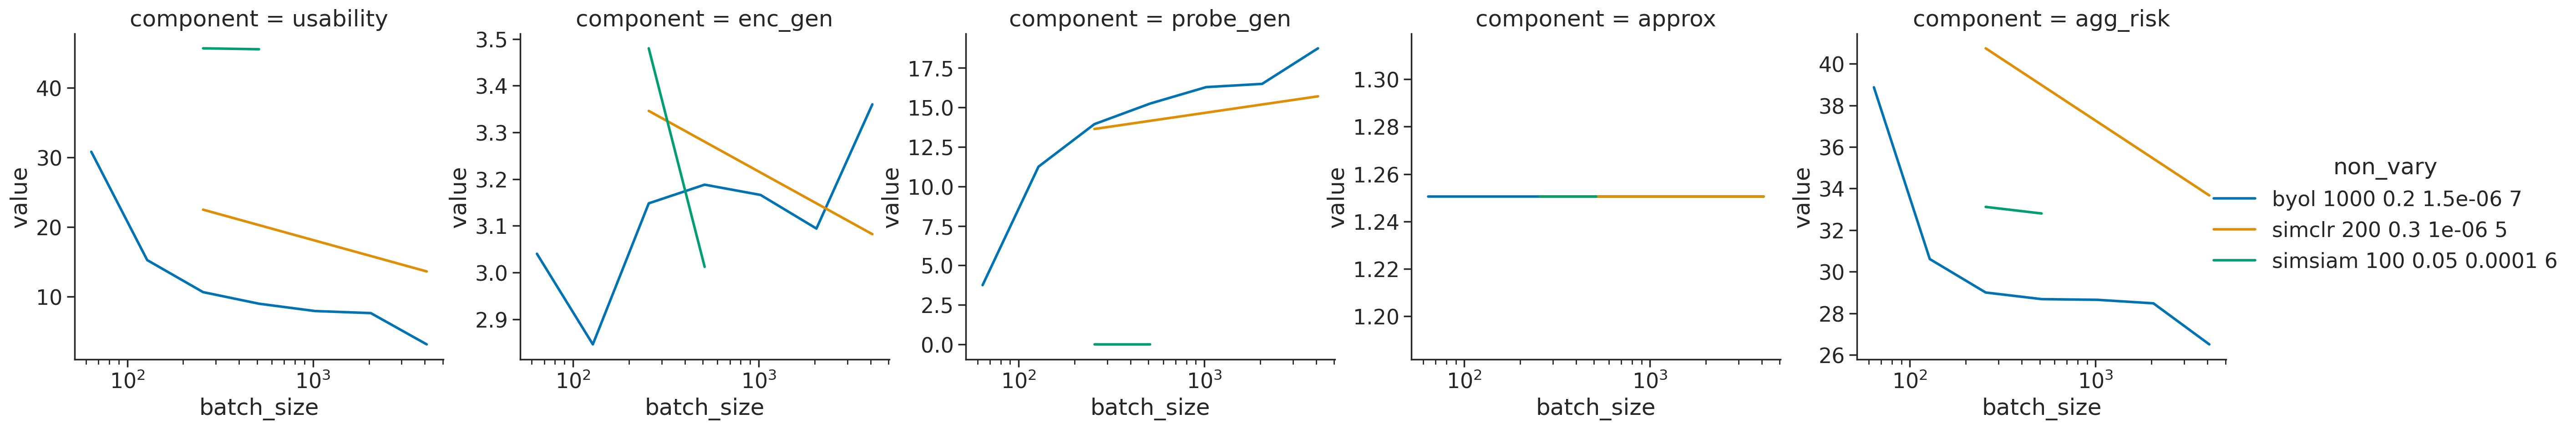

In [12]:
df_bs = melt(get_only_vary(df, ["batch_size"], core_params))

with plot_config():
    g = sns.relplot(data=df_bs, x="batch_size", y="value", hue="non_vary", col="component", kind="line",facet_kws={'sharey': False})
    #plt.setp(g._legend.get_texts(), fontsize=12)
    g.set(xscale="log")

Although we don't have many data points, it seems that probing generalization worsens while usability improves. 

In [13]:
ols_summary(df_bs, "batch_size", outcome="value", condition=['non_vary', 'np.log({treatment})'], f_outcome="log_delta")
#ols_summary(df_bs, "batch_size", outcome="value", condition=['non_vary', '{treatment}'], f_outcome="", alpha=0.01)
#ols_summary(df_bs, "batch_size", outcome="value", condition=['non_vary', 'np.log({treatment})'], f_outcome="", alpha=0.01)

kurtosistest only valid for n>=20 ... continuing anyway, n=11
kurtosistest only valid for n>=20 ... continuing anyway, n=11


                                  usability                                   
Dep. Variable:          np.log(value)   R-squared:                       0.919
Model:                            OLS   Adj. R-squared:                  0.884
Method:                 Least Squares   F-statistic:                     26.47
Date:                Wed, 19 Oct 2022   Prob (F-statistic):           0.000341
Time:                        13:49:42   Log-Likelihood:                0.94130
No. Observations:                  11   AIC:                             6.117
Df Residuals:                       7   BIC:                             7.709
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
rmse: 4.5479001982782385, delta: -0.1
                                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------

kurtosistest only valid for n>=20 ... continuing anyway, n=11
kurtosistest only valid for n>=20 ... continuing anyway, n=11
kurtosistest only valid for n>=20 ... continuing anyway, n=11


                                  probe_gen                                   
Dep. Variable:          np.log(value)   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     114.4
Date:                Wed, 19 Oct 2022   Prob (F-statistic):           2.61e-06
Time:                        13:49:43   Log-Likelihood:                -1.2667
No. Observations:                  11   AIC:                             10.53
Df Residuals:                       7   BIC:                             12.13
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
rmse: 2.635650308226147, delta: -0.1
                                            coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------

kurtosistest only valid for n>=20 ... continuing anyway, n=11
divide by zero encountered in double_scalars


                                   agg_risk                                   
Dep. Variable:          np.log(value)   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.780
Method:                 Least Squares   F-statistic:                     12.81
Date:                Wed, 19 Oct 2022   Prob (F-statistic):            0.00314
Time:                        13:49:43   Log-Likelihood:                 10.722
No. Observations:                  11   AIC:                            -13.44
Df Residuals:                       7   BIC:                            -11.85
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
rmse: 1.7547090777551995, delta: 14.425263417394538
                                            coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

kurtosistest only valid for n>=20 ... continuing anyway, n=11
kurtosistest only valid for n>=20 ... continuing anyway, n=11


### Effect of multicrops

Let's analyze the effect of batch size in controlled settings

**Hypothesis** More multicrops increases the invaraince => bettter generalization of the predictor and better usability (fewer equivalence classes). Generalization of the encoder is not clear: it might have more overfitting on that data.

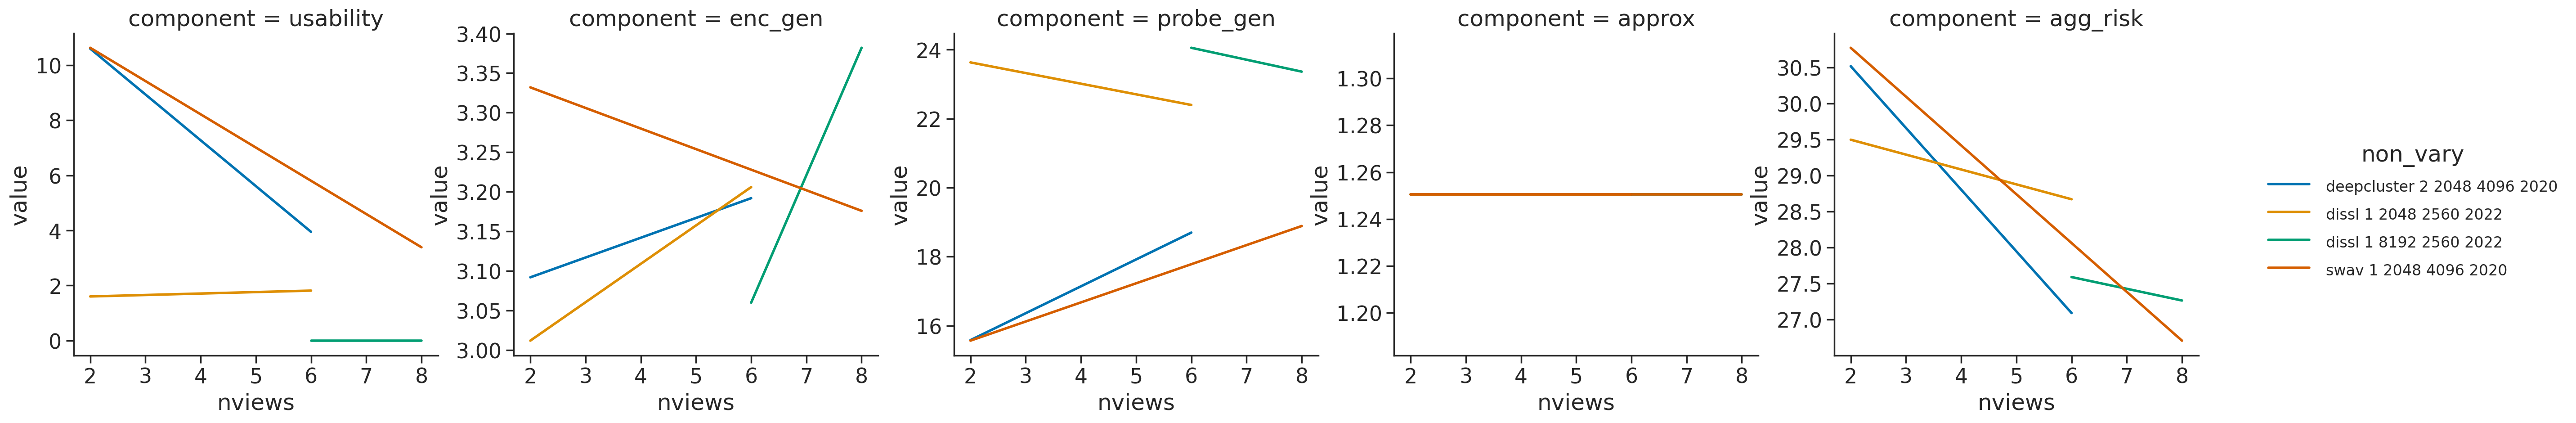

In [14]:
df_nviews = melt(get_only_vary(df, ["nviews"], core_params))

with plot_config():
    g = sns.relplot(data=df_nviews, x="nviews", y="value", hue="non_vary", col="component", kind="line",facet_kws={'sharey': False})
    plt.setp(g._legend.get_texts(), fontsize=12)
    #g.set(yscale="log")
    


In [15]:
#ols_summary(df_nviews, "nviews", condition=['non_vary', 'np.log({treatment})'], f_outcome="log_delta")
#ols_summary(df_nviews, "nviews", condition=['non_vary', '{treatment}'], f_outcome="log_delta")
ols_summary(df_nviews, "nviews",  condition=['non_vary', '{treatment}'], f_outcome="")
#ols_summary(df_nviews, "nviews", condition=['non_vary', 'np.log({treatment})'], f_outcome="")


                                   agg_risk                                   
Dep. Variable:                  value   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.706
Method:                 Least Squares   F-statistic:                     5.197
Date:                Wed, 19 Oct 2022   Prob (F-statistic):              0.103
Time:                        13:49:44   Log-Likelihood:                -6.2835
No. Observations:                   8   AIC:                             22.57
Df Residuals:                       3   BIC:                             22.96
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
rmse: 0.530729981717337, delta: 0
                                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

kurtosistest only valid for n>=20 ... continuing anyway, n=8
kurtosistest only valid for n>=20 ... continuing anyway, n=8
kurtosistest only valid for n>=20 ... continuing anyway, n=8
kurtosistest only valid for n>=20 ... continuing anyway, n=8
divide by zero encountered in double_scalars
kurtosistest only valid for n>=20 ... continuing anyway, n=8
kurtosistest only valid for n>=20 ... continuing anyway, n=8


### Effect of dimensionality

Let's analyze the effect of dimensionality in controlled settings

**Hypothesis** Higher dimensionality should increase usability but decrease generalization of the probe. Encoder generalization is not very clear.

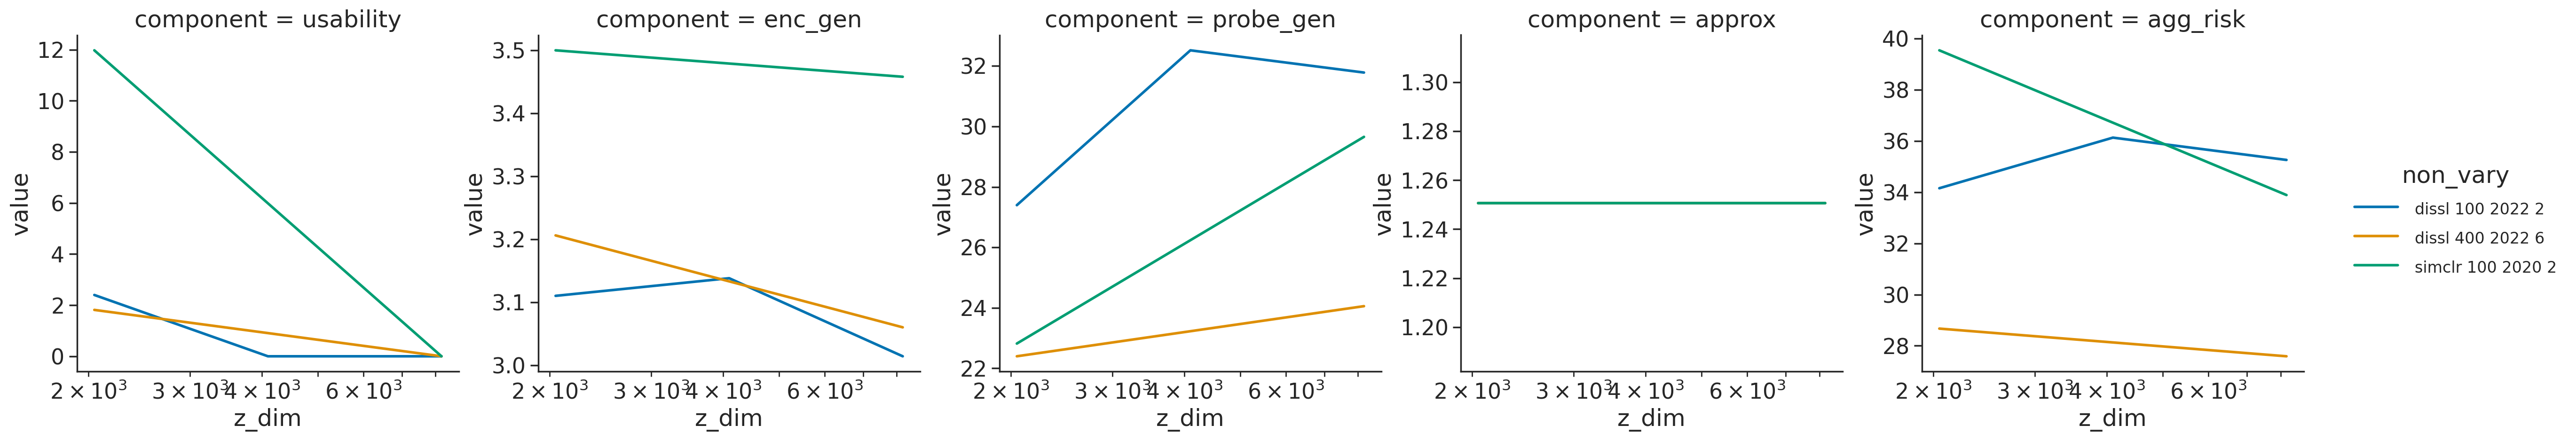

In [16]:
df_zdim = melt(get_only_vary(df, ["z_dim"], core_params))

with plot_config():
    g = sns.relplot(data=df_zdim, x="z_dim", y="value", hue="non_vary", col="component", kind="line",
                    facet_kws={'sharey': False})
    plt.setp(g._legend.get_texts(), fontsize=12)
    g.set(xscale="log")
    #g.set_xticklabels(rotation=30)

In [17]:
#ols_summary(df_zdim, "z_dim", condition=['non_vary', 'np.log({treatment})'], f_outcome="log_delta")
#ols_summary(df_zdim, "z_dim", condition=['non_vary', '{treatment}'], f_outcome="log_delta")
ols_summary(df_zdim, "z_dim")
#ols_summary(df_zdim, "z_dim", condition=['non_vary', 'np.log({treatment})'], f_outcome="")


omni_normtest is not valid with less than 8 observations; 7 samples were given.
omni_normtest is not valid with less than 8 observations; 7 samples were given.
omni_normtest is not valid with less than 8 observations; 7 samples were given.
omni_normtest is not valid with less than 8 observations; 7 samples were given.
omni_normtest is not valid with less than 8 observations; 7 samples were given.


Just as hypothesized, the effect of probe generalization and suability are (the only) significant. For example we see that increasing representation dimensionality from 2000 to 8000 is predicted to improve usability by a huge $5.4$ points but decrease generalization by $3.6$ with a total gain of $1.8$.

Note that directly modifying the diemsnionality was not common under ISSL, but there are two other ways that researchers have indirectly been modifying the representation dimensionality. 

The first one is mostly done in ViT and consists of concatenating representations from different layers of a model. Let us analyse the effect of such dimensionality modification under the assumption that concatenating only impacts dimensionality.

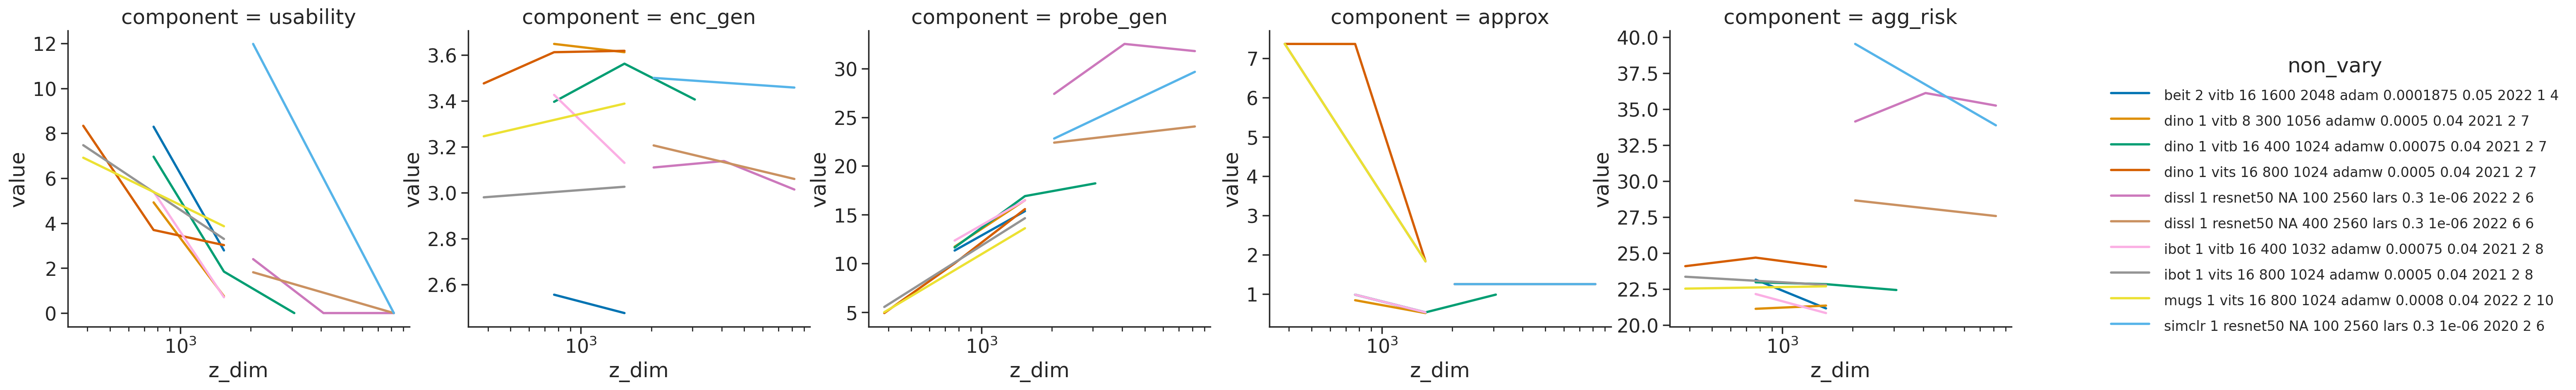

In [18]:
df_zlayer = melt(get_only_vary(df, ["z_dim","z_layer"], core_params, drop_cols=["pretraining_data"]))
#df_zlayer = df_zlayer[df_zlayer.family == "vit"]

with plot_config():
    g = sns.relplot(data=df_zlayer, x="z_dim", y="value", hue="non_vary", col="component", kind="line",
                    facet_kws={'sharey': False})
    plt.setp(g._legend.get_texts(), fontsize=12)
    g.set(xscale="log")
    #g.set_xticklabels(rotation=30)

In [19]:
#ols_summary(df_zlayer, "z_dim", condition=['non_vary', 'np.log({treatment})'], f_outcome="log_delta")
ols_summary(df_zlayer, "z_dim", condition=['non_vary', '{treatment}'], f_outcome="log_delta")
#ols_summary(df_zlayer, "z_dim", condition=['non_vary', 'np.log({treatment})'], f_outcome="")


                                  usability                                   
Dep. Variable:          np.log(value)   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     9.860
Date:                Wed, 19 Oct 2022   Prob (F-statistic):           1.96e-05
Time:                        13:50:31   Log-Likelihood:                -1.3656
No. Observations:                  29   AIC:                             24.73
Df Residuals:                      18   BIC:                             39.77
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
rmse: 1.1887622863619585, delta: 0.7631578947368421
                                                                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------

We see that the the effect of changing the dimensionality due to concatenation has the same effect as changing directly the dimensionality but stronger, which suggests that concatenating is just a cheap way of increasing dimensionality.

Another indirect way researchers increase dimensionality is by using resnets of different widths, this is tyipically motivated by increasing the number of parameters of a model but also has an effect on the dimensionality of the representations.


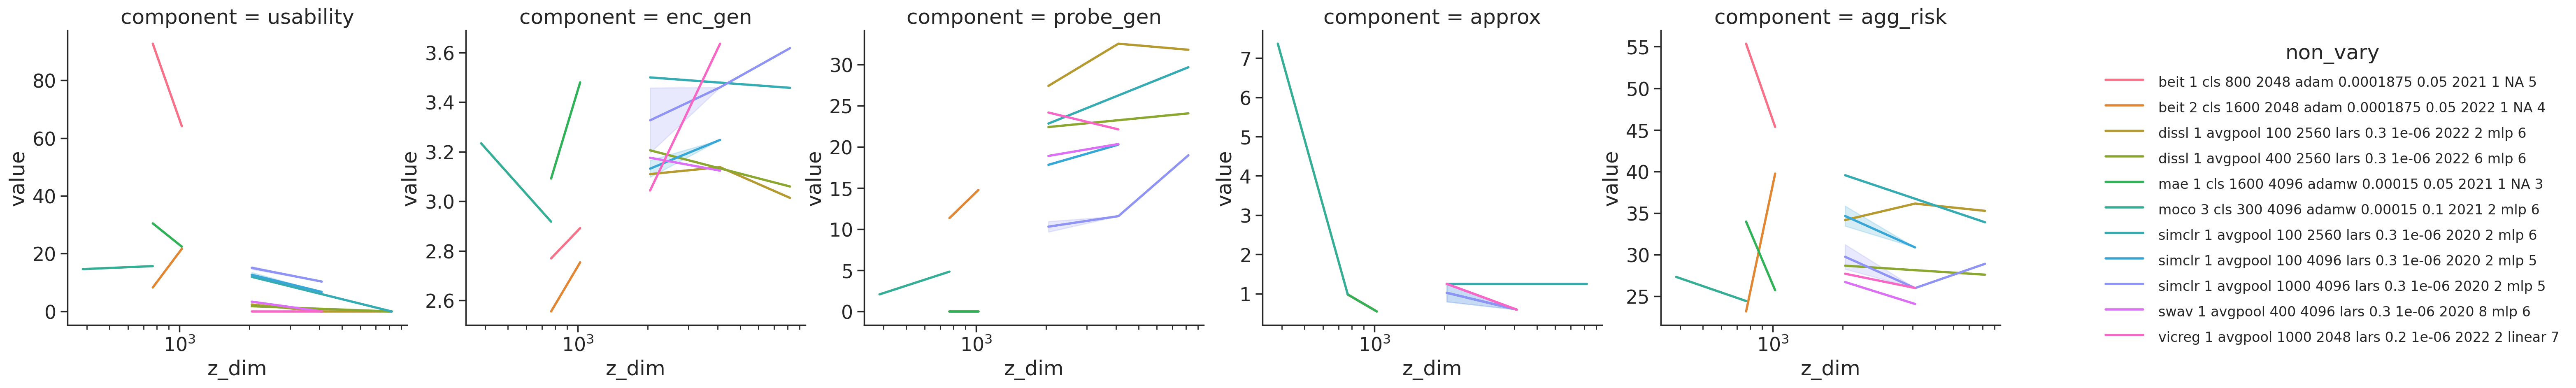

In [20]:
df_zdimarch = melt(get_only_vary(df, ["z_dim","architecture"], core_params, drop_cols=["pretraining_data"]))

with plot_config():
    g = sns.relplot(data=df_zdimarch, x="z_dim", y="value", hue="non_vary", col="component", kind="line",
                    facet_kws={'sharey': False})
    plt.setp(g._legend.get_texts(), fontsize=12)
    g.set(xscale="log")
    #g.set_xticklabels(rotation=30)

In [21]:
#ols_summary(df_zdimarch, "z_dim", condition=['non_vary', 'np.log({treatment})'], f_outcome="log_delta")
#ols_summary(df_zdimarch, "z_dim", condition=['non_vary', '{treatment}'], f_outcome="log_delta")
#ols_summary(df_zdimarch, "z_dim", condition=['non_vary', 'np.log({treatment})'], f_outcome="")
ols_summary(df_zdimarch, "z_dim", condition=['non_vary', '{treatment}'], f_outcome="")

                                  probe_gen                                   
Dep. Variable:                  value   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     174.3
Date:                Wed, 19 Oct 2022   Prob (F-statistic):           6.22e-26
Time:                        13:51:21   Log-Likelihood:                -73.511
No. Observations:                  45   AIC:                             171.0
Df Residuals:                      33   BIC:                             192.7
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
rmse: 1.2394262063898067, delta: 0
                                                                            coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

### Effect of architecture

Now let us look more specifically at the general effect of the architecture.

#### Size
First let us consider the effect of the size of the architecture

**Hypothesis** Larger architectures should first and foremost decrease the approximation gap. Furthermore larger models typically have larger diemnsionality and thus from the previous paragraph we hypothesize that the probing generalization should worsen and the usability should improve.

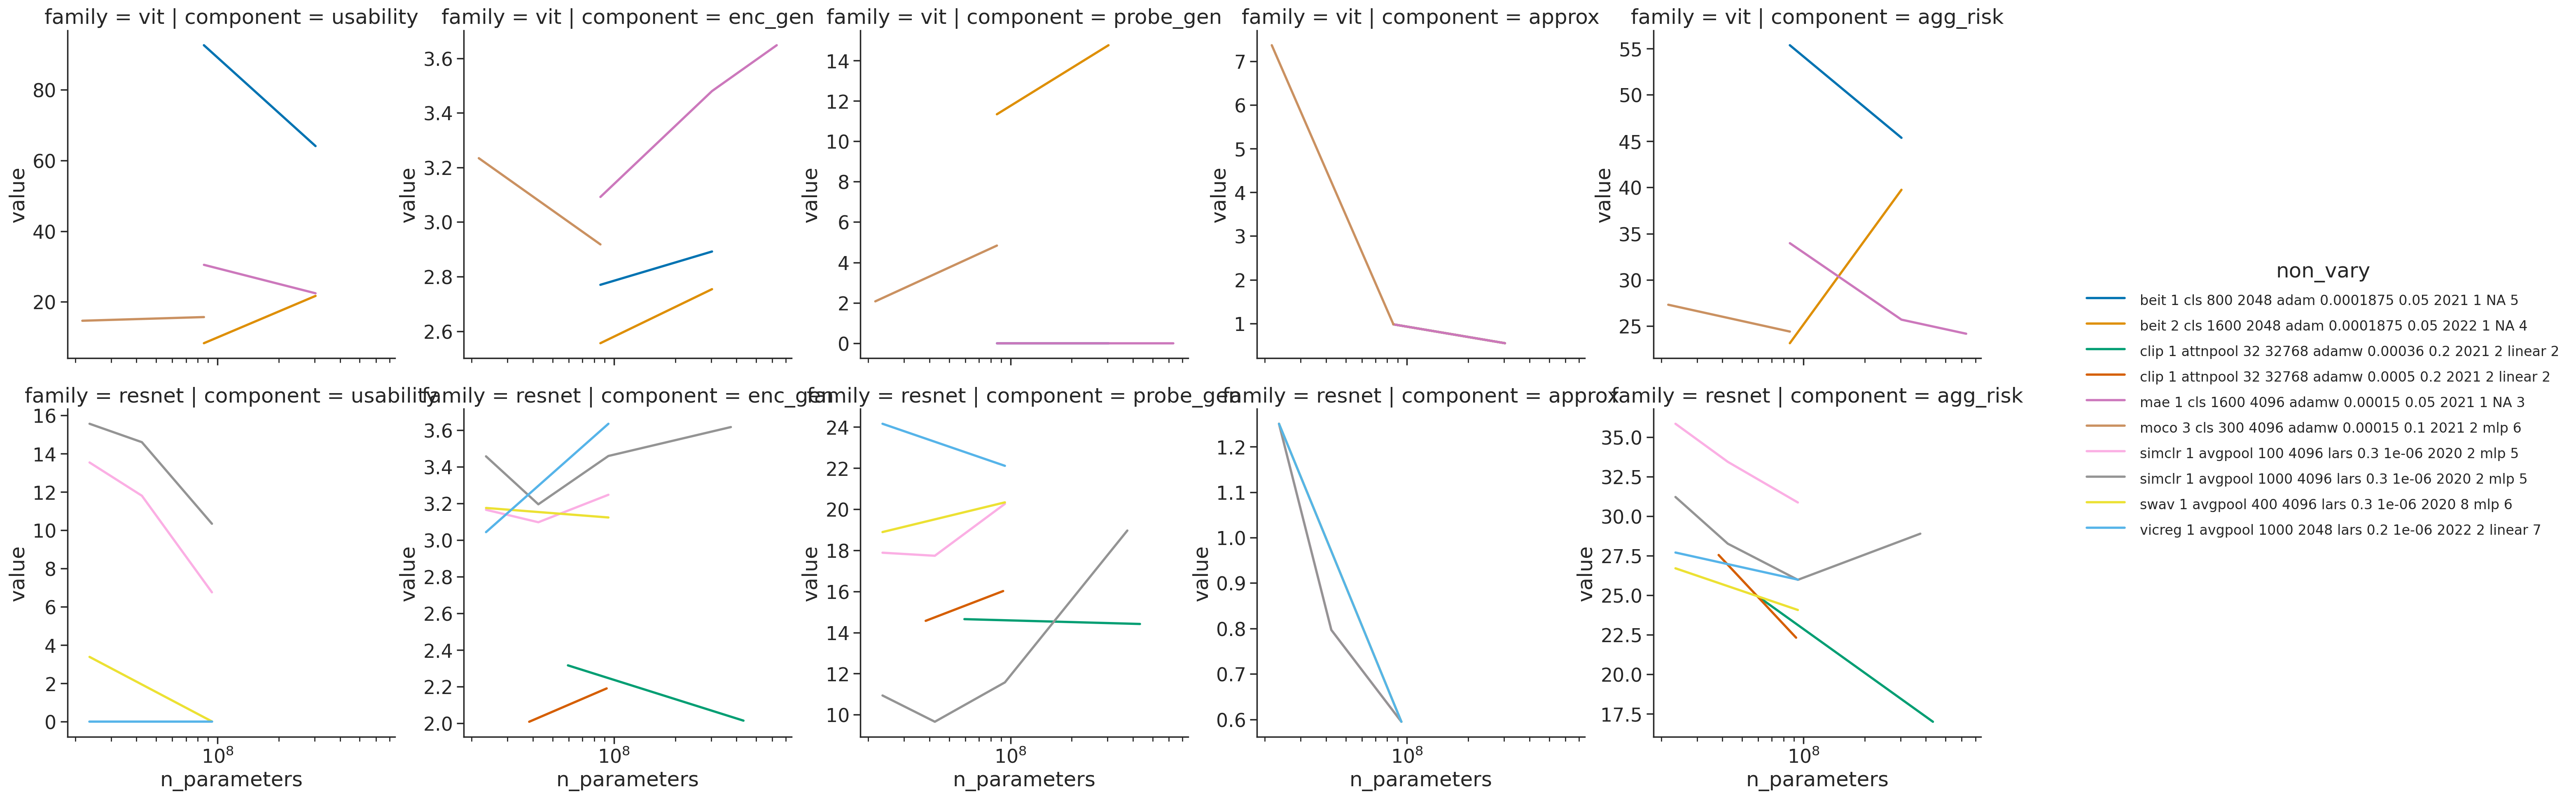

In [22]:
disregard = ["img_size","patch_size","z_dim"]
df_arch = melt(get_only_vary(df.drop(columns=disregard), 
                             ["architecture"], 
                             [c for c in core_params if c not in disregard],
                              drop_cols=["pretraining_data"]))
#df_arch.n_parameters = df_arch.n_parameters // int(5e6) * int(5e6)

with plot_config():
    g = sns.relplot(data=df_arch, x="n_parameters", y="value", hue="non_vary", col="component", row="family", kind="line",
                    facet_kws={'sharey': False})
    plt.setp(g._legend.get_texts(), fontsize=12)
    g.set(xscale="log")
    #g.set_xticklabels(rotation=30)

We see that the clearest effect is for the approximation gap which decreases drastically for larger models. Note that it is not clear whether the effect of number of parameters is linear and so the following analysis is not great.

In [23]:
#ols_summary(df_arch, "n_parameters", condition=['non_vary', 'np.log({treatment})'], f_outcome="log_delta")
#ols_summary(df_arch, "n_parameters", condition=['non_vary', '{treatment}'], f_outcome="log_delta")
ols_summary(df_arch, "n_parameters", condition=['non_vary', 'np.log({treatment})'], f_outcome="")
#ols_summary(df_arch, "n_parameters", condition=['non_vary', '{treatment}'], f_outcome="")

                                  probe_gen                                   
Dep. Variable:                  value   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                     42.04
Date:                Wed, 19 Oct 2022   Prob (F-statistic):           3.01e-08
Time:                        13:51:43   Log-Likelihood:                -41.364
No. Observations:                  24   AIC:                             104.7
Df Residuals:                      13   BIC:                             117.7
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
rmse: 1.3560126088192062, delta: 0
                                                                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

We now have that the number of parameters has a high impact on the approximation gap, as expected. In particular we have that increasing the log10 parameters by one, i.e., multiplying the number parameters by 10 will improve approximation by $\approx-6$. 

#### ViT vs ResNet
Now that we have considered the effect of number of parameters, let us consider the effect of using ViT vs ResNet

**Hypothesis** This is very hard to say, but the encoder generalization likely worsen when going to ViT while approx error probably improves.

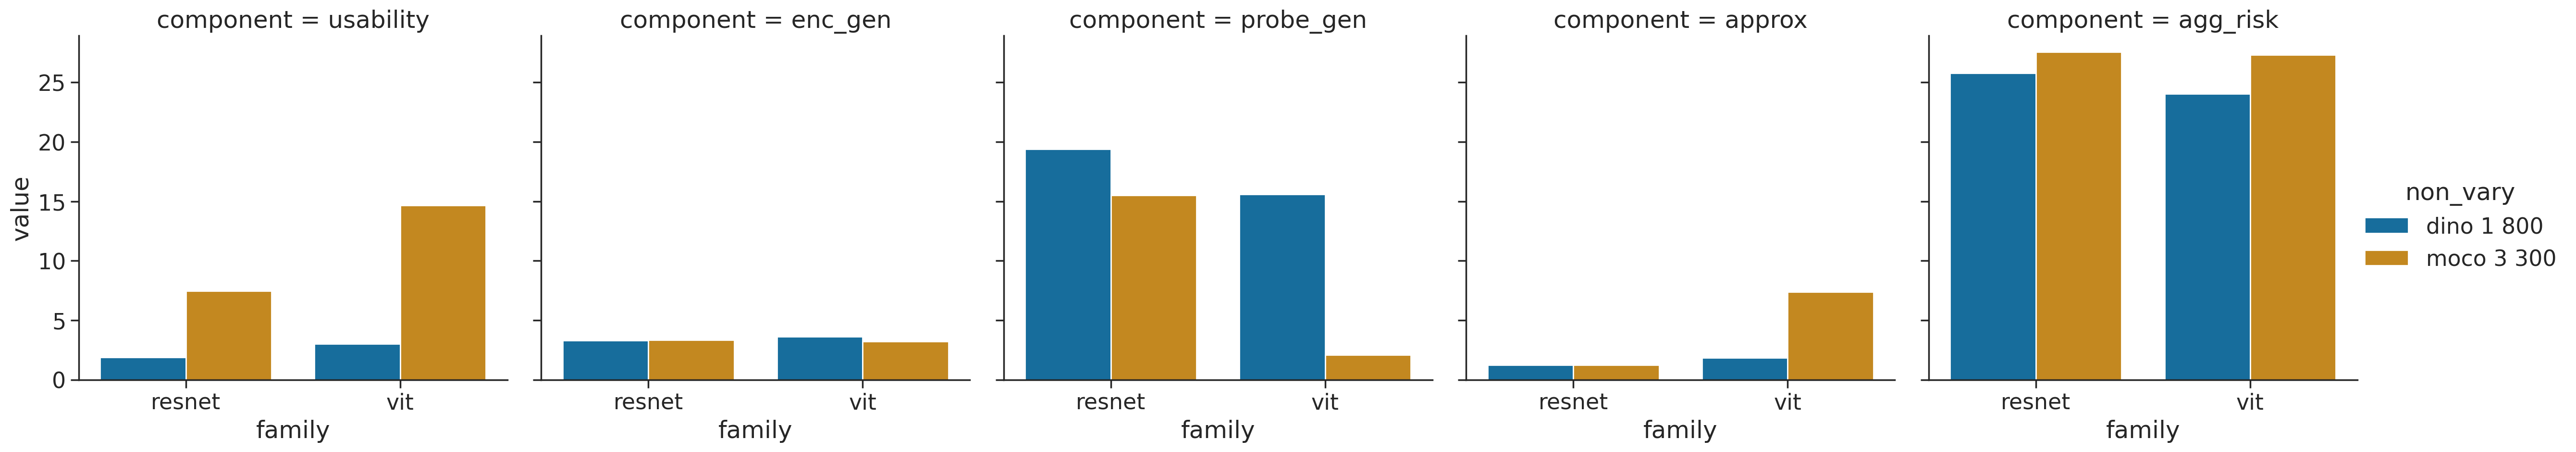

In [24]:
curr_df = df.copy()
curr_df.n_parameters = curr_df.n_parameters // int(30e6) * int(30e6) # coarse grains

# varying over the 
df_family = melt(get_only_vary(curr_df, ["family"],  ["family","objective","n_parameters","version","epochs"]))
df_family= df_family[~df_family.top1acc_in1k_official.isna()] # don't take all the vit models that don't have the official z_layer


with plot_config():
    g = sns.catplot(data=df_family, x="family", y="value", hue="non_vary", col="component", kind="bar",
                    facet_kws={'sharey': False})
    #plt.setp(g._legend.get_texts(), fontsize=12)

In [25]:
#ols_summary(df_family, "family", condition=['non_vary', '{treatment}'], f_outcome="log_delta")
ols_summary(df_family, "family", condition=['non_vary', '{treatment}'], f_outcome="")

omni_normtest is not valid with less than 8 observations; 4 samples were given.
omni_normtest is not valid with less than 8 observations; 4 samples were given.
omni_normtest is not valid with less than 8 observations; 4 samples were given.
omni_normtest is not valid with less than 8 observations; 4 samples were given.
omni_normtest is not valid with less than 8 observations; 4 samples were given.


We see that there seems to be nothing significative, most likely because we only have 2 models that are trained on RN and ViT. This will likely be more conclusive when performing causal analysis. Note furethermore that there are other parameters (training hyperparameters) that we did not control.

#### Effect of patch size

Another important component of architecture that is not taken into account by number ofa parameters and family, is the patch size of ViT. 

**Hypothesis** This is very hard to say, but the encoder generalization likely worsen when going to ViT while approx error probably improves.

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

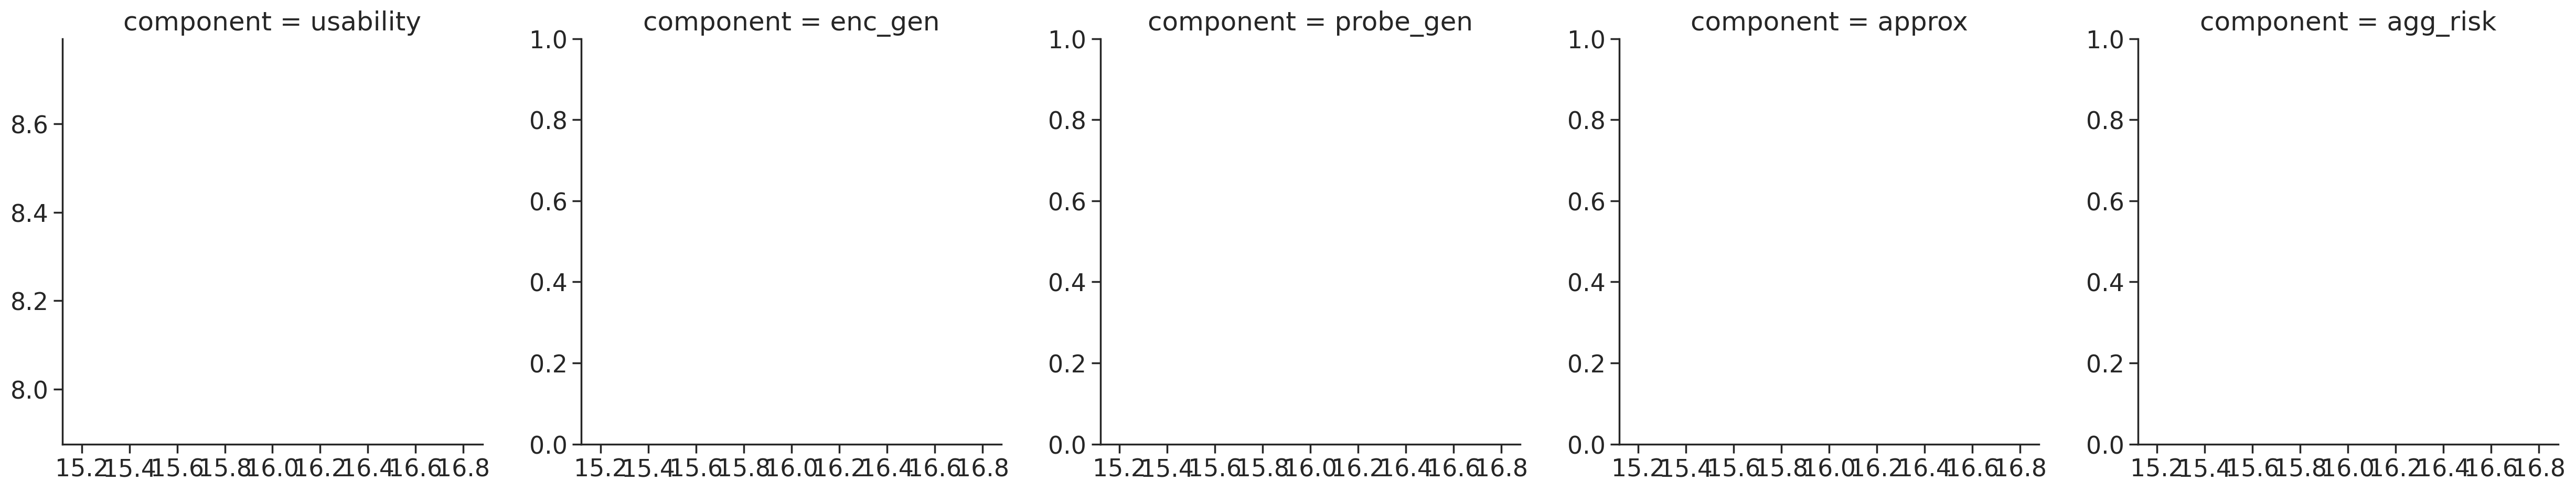

In [27]:

df_patch = melt(get_only_vary(df, ["patch_size"],  core_params, drop_cols=["data"]))#,
df_patch = df_patch[df_patch.family == "vit"]
#df_patch = df_patch[~df_patch.value.isna()]

with plot_config():
    g = sns.relplot(data=df_patch, x="patch_size", y="value", hue="non_vary", col="component", kind="line",
                    facet_kws={'sharey': False})
    plt.setp(g._legend.get_texts(), fontsize=12)

In [28]:
df_patch.patch_size = df_patch.patch_size.astype("int")
#ols_summary(df_patch, "patch_size", condition=['non_vary', 'np.log({treatment})'], f_outcome="log_delta")
ols_summary(df_patch, "patch_size", condition=['non_vary', '{treatment}'], f_outcome="log_delta")
#ols_summary(df_patch, "patch_size", condition=['non_vary', 'np.log({treatment})'], f_outcome="")
#ols_summary(df_patch, "patch_size", condition=['non_vary', '{treatment}'], f_outcome="")

AttributeError: 'NoneType' object has no attribute 'summary2'

We see that the aggregated performance significantly improves with smaller patch_size on all components! 

### Effect of projection 

Another hyperparameter that people have found to be very important is the architecture of the projection head.

**Hypothesis**: from ISSL we know that non linear projection heads on only branch can help optimization of the representations (usability and probing generalization), but on both sides they do not ensure linear predictability anymore (drop on usability). 

#### Architecture

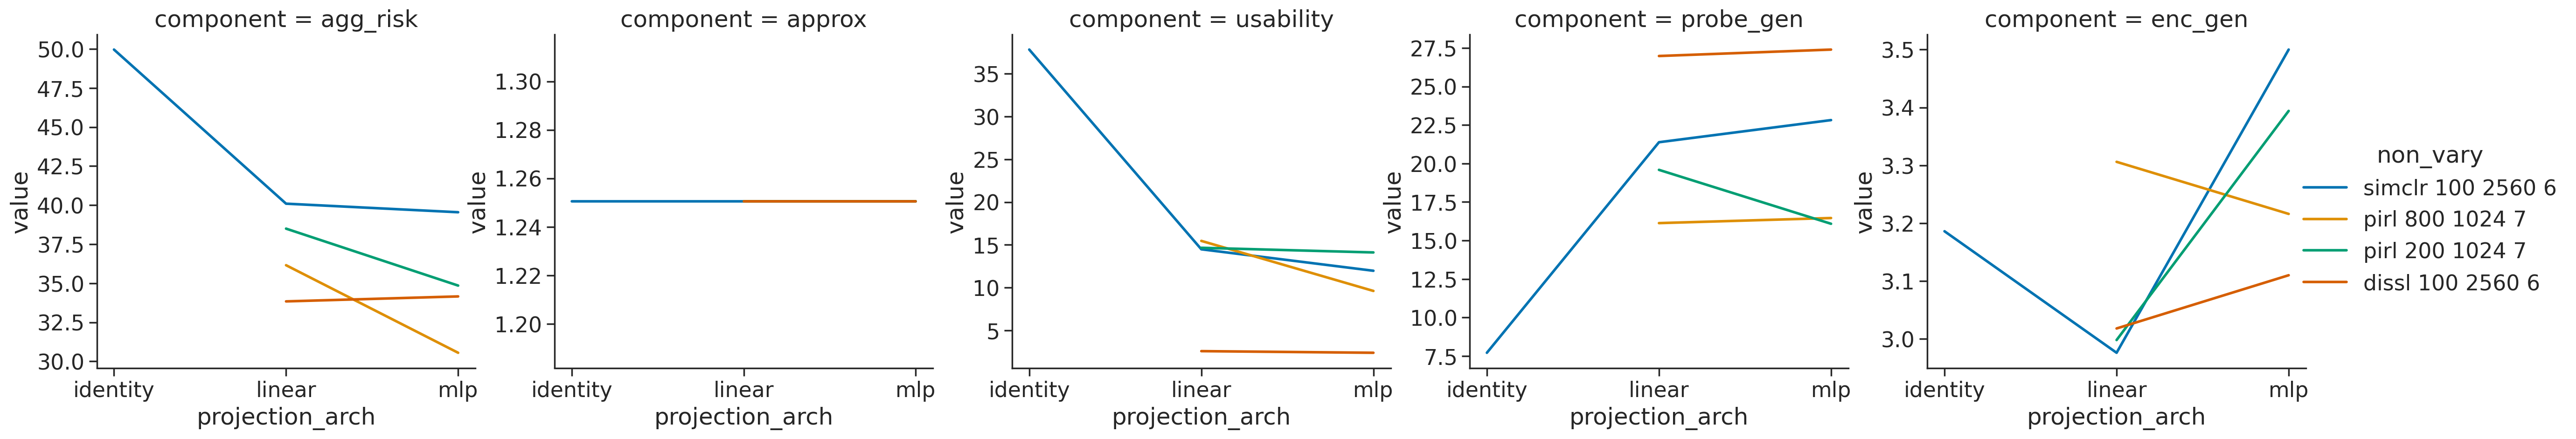

In [29]:
df_proj = melt(get_only_vary(df, ["projection_arch"], core_params, 
                            drop_cols=["year","optimizer","learning_rate", 'weight_decay']))

with plot_config():
    g=sns.relplot(data=df_proj.sort_values("projection_arch"), x="projection_arch", y="value", hue="non_vary", 
                  kind="line", col="component", facet_kws={'sharey': False})
#sns.move_legend(g, "upper center", bbox_to_anchor=(0., 0.5, 0.7, 1.102))

In [30]:
ols_summary(df_proj, "projection_arch", condition=['non_vary', '{treatment}'], f_outcome="log_delta")
#ols_summary(df_proj, "projection_arch", condition=['non_vary', '{treatment}'], f_outcome="")

kurtosistest only valid for n>=20 ... continuing anyway, n=9
kurtosistest only valid for n>=20 ... continuing anyway, n=9
kurtosistest only valid for n>=20 ... continuing anyway, n=9


                                  usability                                   
Dep. Variable:          np.log(value)   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     62.24
Date:                Wed, 19 Oct 2022   Prob (F-statistic):            0.00314
Time:                        13:53:21   Log-Likelihood:                 9.9427
No. Observations:                   9   AIC:                            -7.885
Df Residuals:                       3   BIC:                            -6.702
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
rmse: 0.9881311883278139, delta: -0.1
                                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

kurtosistest only valid for n>=20 ... continuing anyway, n=9
kurtosistest only valid for n>=20 ... continuing anyway, n=9
kurtosistest only valid for n>=20 ... continuing anyway, n=9
divide by zero encountered in double_scalars


                                  probe_gen                                   
Dep. Variable:          np.log(value)   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     33.58
Date:                Wed, 19 Oct 2022   Prob (F-statistic):            0.00777
Time:                        13:53:22   Log-Likelihood:                 14.624
No. Observations:                   9   AIC:                            -17.25
Df Residuals:                       3   BIC:                            -16.06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
rmse: 0.9132655645288823, delta: -0.1
                                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

kurtosistest only valid for n>=20 ... continuing anyway, n=9
kurtosistest only valid for n>=20 ... continuing anyway, n=9


We see that usability improves while probe gen worsen's.
One issues is that with simclr and dissl we don't actually differentiate between proj of the teacher or student.
Let's consider the more fine grained now.

In [31]:
dissl_proj = ["dissl_resnet50_dNone_e100_m2_headTMlpSMlp","dissl_resnet50_dNone_e100_m2_headTLinSLin","dissl_resnet50_dNone_e100_m2"]
dissl_proj = [d.lower() for d in dissl_proj ]
df_dissl_proj = df.loc[df.index.isin(dissl_proj)]
df_dissl_proj[COMPONENTS]

usability   enc_gen  probe_gen  \
enc                                                                         
dissl_resnet50_dnone_e100_m2                2.399765  3.110000  27.395656   
dissl_resnet50_dnone_e100_m2_headtlinslin   2.590919  3.018001  26.978502   
dissl_resnet50_dnone_e100_m2_headtmlpsmlp   2.565318  3.097999  26.962104   

                                             approx   agg_risk  
enc                                                             
dissl_resnet50_dnone_e100_m2               1.250579  34.156001  
dissl_resnet50_dnone_e100_m2_headtlinslin  1.250579  33.838001  
dissl_resnet50_dnone_e100_m2_headtmlpsmlp  1.250579  33.875999

We see that for dissl it has little effect, with the best being the asummentric proposed in ISSL.

In [32]:
simclr_proj=df.query("`objective` == 'simclr' and `nviews` == 2 and `epochs`==100 and `z_dim` == 2048 and `architecture`=='resnet50'")
simclr_proj[COMPONENTS]

usability   enc_gen  probe_gen  \
enc                                                                            
simclr_resnet50_dnone_e100_m2                  8.682085  3.086001  22.103337   
simclr_resnet50_dnone_e100_m2_headtlinslin    14.486636  2.976000  21.380785   
simclr_resnet50_dnone_e100_m2_headtmlpslin    11.976893  3.500000  22.818530   
simclr_resnet50_dnone_e100_m2_headtmlpsmlp     8.631818  3.284001  22.043604   
simclr_resnet50_dnone_e100_m2_headtnonesnone  37.809981  3.185999   7.713440   
simclr_rn50_bs4096_ep100                      13.547805  3.166002  17.883615   

                                                approx   agg_risk  
enc                                                                
simclr_resnet50_dnone_e100_m2                 1.250579  35.122001  
simclr_resnet50_dnone_e100_m2_headtlinslin    1.250579  40.094000  
simclr_resnet50_dnone_e100_m2_headtmlpslin    1.250579  39.546001  
simclr_resnet50_dnone_e100_m2_headtmlpsmlp    1.250579  35.210001  
simclr_resnet50_dnone_e100_m2_headtnonesnone  1.250579  49.959999  
simclr_rn50_bs4096_ep100                      1.250579  35.848001

We see that for simclr it has a large effect, with the best being by far MLP / MLP, and MLP/LIN giving little gains compared to LIN/LIN.

### Effect of data

Until now we have not talked about an important part of the SSL pipeline: the pretraining data. We investigate that now.

#### Effect of data percentage

First let us consider the effect of training on more data from the same distribution.

**Hypothesis** Training on more in distribution data should improve mostly encoder generalization. 

Unfortunately there will also be a mistake on how we evaluate because models that were trained on a subset of imagenet will actually have a encoder generalization component in the usability (because the training set of imagenet will now not have been seen). As a result we will actually likely see an improvement on usability and a **decrease** in encoder generalization when increasing the pretraining data (because usability now takes into account encoder generalization and so the delta will be smaller when compariong to pure encoder generalization). This is a very unfortunate problement which doesn't seem to have a simple solution, I think I will thus drop those risk decomposition results.

In [33]:
df_dataperc = melt(get_only_vary(df, ["pretraining_data"], core_params, 
                            drop_cols=[]))
# only select if taking percentages
df_dataperc = df_dataperc.loc[["%" in d for d in df_dataperc.pretraining_data],:]

if len(df_dataperc) > 0:
    with plot_config():
        g=sns.catplot(data=df_dataperc, x="pretraining_data", y="value", hue="non_vary", 
                      kind="bar", col="component", facet_kws={'sharey': False})
#sns.move_legend(g, "upper center", bbox_to_anchor=(0., 0.5, 0.7, 1.102))

#### Effect of IN20k

Prewviously we saw the effect of the training size (percentage) now let us consider different datasets.

**hypothesis** if the distribution of the training set there will be some shift which will likely worst then encoder generalization. But at the same time if the data increases we will likely see better usability and probing generalization.

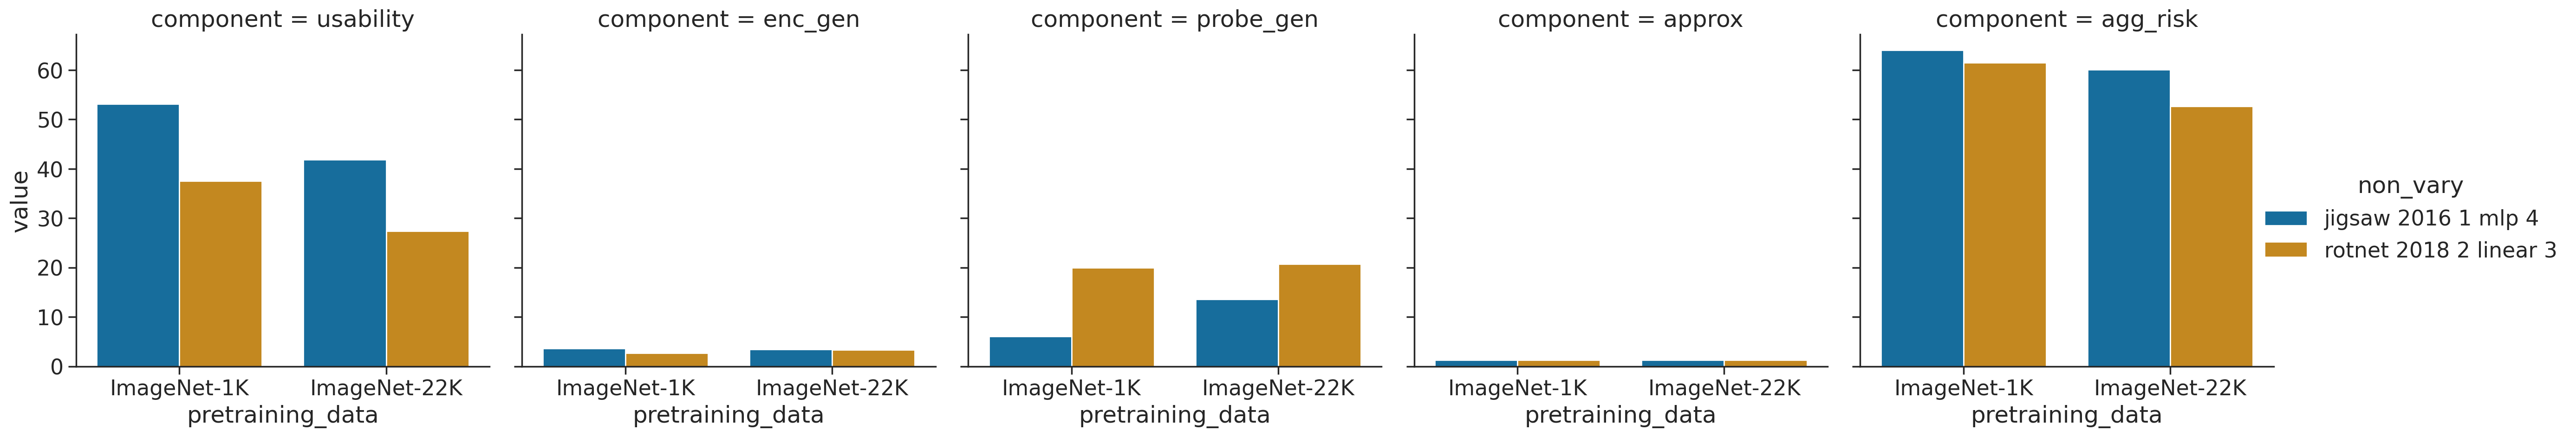

In [35]:
df_data = melt(get_only_vary(df, ["pretraining_data"], core_params, 
                            drop_cols=[]))
# only select if not taking percentages
df_data = df_data.loc[["%" not in d for d in df_data.pretraining_data ],:]

if len(df_data) > 0:
    with plot_config():
        g=sns.catplot(data=df_data, x="pretraining_data", y="value", hue="non_vary", 
                      kind="bar", col="component", facet_kws={'sharey': False})
#sns.move_legend(g, "upper center", bbox_to_anchor=(0., 0.5, 0.7, 1.102))

In [38]:
#ols_summary(df_data, "pretraining_data", condition=['non_vary', '{treatment}'], f_outcome="log_delta")
ols_summary(df_data, "pretraining_data", condition=['non_vary', '{treatment}'], f_outcome="")

                                  usability                                   
Dep. Variable:                  value   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     555.8
Date:                Wed, 19 Oct 2022   Prob (F-statistic):             0.0300
Time:                        13:55:06   Log-Likelihood:               -0.53337
No. Observations:                   4   AIC:                             7.067
Df Residuals:                       1   BIC:                             5.226
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
rmse: 0.2764858305454245, delta: 0
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

omni_normtest is not valid with less than 8 observations; 4 samples were given.
omni_normtest is not valid with less than 8 observations; 4 samples were given.
omni_normtest is not valid with less than 8 observations; 4 samples were given.
omni_normtest is not valid with less than 8 observations; 4 samples were given.
omni_normtest is not valid with less than 8 observations; 4 samples were given.
divide by zero encountered in double_scalars
omni_normtest is not valid with less than 8 observations; 4 samples were given.


Although the trend are as predicted, we see that the results are not statistically significant, likely because we only have 2 models. THis will probably be solved once we do a general caussal discovery.

#### Effect of finetuning

In [39]:
curr_df = df.copy()
curr_df["is_finetuned"] = curr_df.finetuning_data.isna()
df_ft = melt(get_only_vary(curr_df, ["is_finetuned"], core_params+["is_finetuned"], 
                            drop_cols=[]))

if len(df_ft) > 0:
    with plot_config():
        g=sns.catplot(data=df_ft, x="is_fintetuned", y="value", hue="non_vary", 
                      kind="bar", col="component", facet_kws={'sharey': False})
#sns.move_legend(g, "upper center", bbox_to_anchor=(0., 0.5, 0.7, 1.102))